tgb - 4/20/2020 - Adapting Ankitesh's climate-invariant training notebook for hyperparameter optimization by David Walling. 

In [1]:
import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
# import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
# from climate_invariant import *
from tensorflow.keras import layers
import datetime
from climate_invariant_utils import *
import yaml


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog


## Global Variables

In [2]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [3]:
TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData/'
path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'
path_hyam = 'hyam_hybm.pkl'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)

scale_dict = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')

In [4]:
inter_dim_size = 40 #required for interpolation layer

In [5]:
class DataGeneratorClimInv(DataGenerator):
    
    def __init__(self, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None,
             rh_trans=True,t2tns_trans=True,
             lhflx_trans=True,
             scaling=True,interpolate=True,
             hyam=None,hybm=None,                 
             inp_subRH=None,inp_divRH=None,
             inp_subTNS=None,inp_divTNS=None,
             lev=None, interm_size=40,
             lower_lim=6,
             is_continous=True,Tnot=5,
                mode='train',portion=1):
        
        self.scaling = scaling
        self.interpolate = interpolate
        self.rh_trans = rh_trans
        self.t2tns_trans = t2tns_trans
        self.lhflx_trans = lhflx_trans
        self.inp_shape = 64
        self.mode=mode
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off) ## call the base data generator
        self.inp_sub = self.input_transform.sub
        self.inp_div = self.input_transform.div
        if rh_trans:
            self.qv2rhLayer = QV2RHNumpy(self.inp_sub,self.inp_div,inp_subRH,inp_divRH,hyam,hybm)
        
        if lhflx_trans:
            self.lhflxLayer = LhflxTransNumpy(self.inp_sub,self.inp_div,hyam,hybm)
            
        if t2tns_trans:
            self.t2tnsLayer = T2TmTNSNumpy(self.inp_sub,self.inp_div,inp_subTNS,inp_divTNS,hyam,hybm)
            
        if scaling:
            self.scalingLayer = ScalingNumpy(hyam,hybm)
            self.inp_shape += 1
                    
        if interpolate:
            self.interpLayer = InterpolationNumpy(lev,is_continous,Tnot,lower_lim,interm_size)
            self.inp_shape += interm_size*2 + 4 + 30 ## 4 same as 60-64 and 30 for lev_tilde.size
            
        # tgb - 7/9/2020 - Test only training on a subset of the data determined by portion
        self.portion = portion
            
        
    def __getitem__(self, index):
        
        # If portion<1, only look at a subset of the data by putting an upper bound on index
        if self.portion<1: index = index % round(1/self.portion)
        elif self.portion>1: print('Setting portion=1 because portion>1')
        elif self.portion<0: print('Setting portion=1 because portion<0')
        
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size

        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]

        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        # Normalize
        X_norm = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        X_result = X_norm
        
        if self.rh_trans:
            X_result = self.qv2rhLayer.process(X_result) 
            
        if self.lhflx_trans:
            X_result = self.lhflxLayer.process(X_result)
            X_result = X_result[:,:64]
            X = X[:,:64]
            
        if self.t2tns_trans:
            X_result = self.t2tnsLayer.process(X_result)
        
        if self.scaling:
            scalings = self.scalingLayer.process(X) 
            X_result = np.hstack((X_result,scalings))
        
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
            

        if self.mode=='val':
            return xr.DataArray(X_result), xr.DataArray(Y)
        return X_result,Y
    
    ##transforms the input data into the required format, take the unnormalized dataset
    def transform(self,X):
        X_norm = self.input_transform.transform(X)
        X_result = X_norm
        
        if self.rh_trans:
            X_result = self.qv2rhLayer.process(X_result)  
        
        if self.lhflx_trans:
            X_result = self.lhflxLayer.process(X_result)
            X_result = X_result[:,:64]
            X = X[:,:64]

        if self.t2tns_trans:
            X_result = self.t2tnsLayer.process(X_result)
        
        if self.scaling:
            scalings = self.scalingLayer.process(X) 
            X_result = np.hstack((X_result,scalings))
        
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
            

        return X_result

## Data Generators

In [6]:
geography = False # True for real-geography dataset, false otherwise

In [7]:
if geography:
    scale_dict['PTTEND']=scale_dict['TPHYSTND']
    scale_dict['PTEQ']=scale_dict['PHQ']

### Choose between aquaplanet and realistic geography here

In [8]:
if geography: path = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/geography/'
else: path = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'
    
# if geography: TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData/'
# else: TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/geography/'

### Data Generator using RH

In [9]:
scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%
scale_dict_RH['PTTEND']=scale_dict_RH['TPHYSTND']
scale_dict_RH['PTEQ']=scale_dict_RH['PHQ']

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if geography: out_vars_RH = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']
else: out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

In [10]:
train_gen_RH = DataGenerator(
    data_fn = path+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = path+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True
)

In [11]:
train_gen_RH[0][0].shape

(1024, 64)

In [12]:
train_gen_RH[0][1].shape

(1024, 64)

#### For positve sepearation (required since we are going to use scaling)

In [13]:
TRAINFILE_RH = 'PosCRH_CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'PosCRH_CI_RH_M4K_NORM_norm.nc'

train_gen_RH_pos = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True
)

#### For negative sepearation

In [14]:
TRAINFILE_RH = 'NegCRH_CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'NegCRH_CI_RH_M4K_NORM_norm.nc'

train_gen_RH_neg = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True
)

### Data Generator using TNS

In [15]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = out_vars_RH
# if geography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']
# else: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_TNS = 'CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'CI_TNS_M4K_NORM_norm.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_NORM_valid.nc'

In [16]:
train_gen_TNS = DataGenerator(
    data_fn = path+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

In [17]:
train_gen_TNS[0][0].shape

(1024, 64)

#### For positive 

In [18]:
TRAINFILE_TNS = 'PosCRH_CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'PosCRH_CI_TNS_M4K_NORM_norm.nc'

train_gen_TNS_pos = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

#### For negative 

In [19]:
TRAINFILE_TNS = 'NegCRH_CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'NegCRH_CI_TNS_M4K_NORM_norm.nc'

train_gen_TNS_neg = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

### Data Generator Combined 

In [20]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if geography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']
else: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [21]:
## this won't be used just to show we can use it overall
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

train_gen = DataGeneratorClimInv(
    data_fn = path+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans=True,t2tns_trans=True,
    lhflx_trans=True,scaling=False,interpolate=False)

valid_gen = DataGeneratorClimInv(
    data_fn = path+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans=True,t2tns_trans=True,
    lhflx_trans=True,scaling=False,interpolate=False
)

In [22]:
train_gen[0][0].shape

(1024, 64)

#### For positive

In [23]:
TRAINFILE = 'PosCRH_CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'PosCRH_CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'PosCRH_CI_SP_M4K_valid.nc'

train_gen_pos = DataGeneratorClimInv(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_pos.input_transform.sub, inp_divRH=train_gen_RH_pos.input_transform.div,
    inp_subTNS=train_gen_TNS_pos.input_transform.sub,inp_divTNS=train_gen_TNS_pos.input_transform.div,
    is_continous=True
)

valid_gen_pos = DataGeneratorClimInv(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_pos.input_transform.sub, inp_divRH=train_gen_RH_pos.input_transform.div,
    inp_subTNS=train_gen_TNS_pos.input_transform.sub,inp_divTNS=train_gen_TNS_pos.input_transform.div,
    is_continous=True
)

In [24]:
train_gen_pos[0][0].shape

(1024, 179)

#### For Negative

In [25]:
TRAINFILE = 'NegCRH_CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'NegCRH_CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'NegCRH_CI_SP_M4K_valid.nc'

### we don't scale this network
train_gen_neg = DataGeneratorClimInv(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_neg.input_transform.sub, inp_divRH=train_gen_RH_neg.input_transform.div,
    inp_subTNS=train_gen_TNS_neg.input_transform.sub,inp_divTNS=train_gen_TNS_neg.input_transform.div,
    is_continous=True,
    scaling=False
)

valid_gen_neg = DataGeneratorClimInv(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_neg.input_transform.sub, inp_divRH=train_gen_RH_neg.input_transform.div,
    inp_subTNS=train_gen_TNS_neg.input_transform.sub,inp_divTNS=train_gen_TNS_neg.input_transform.div,
    is_continous=True,
    scaling=False
)

In [26]:
train_gen_neg[0][0].shape

(1024, 178)

## Building the Model

### For Positive

In [45]:
inp = Input(shape=(179,)) ## input after rh and tns transformation
offset = 65
inp_TNS = inp[:,offset:offset+2*inter_dim_size+4]
offset = offset+2*inter_dim_size+4
lev_tilde_before = inp[:,offset:offset+30]
offset = offset+30

densout = Dense(128, activation='linear')(inp_TNS)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
denseout = Dense(2*inter_dim_size+4, activation='linear')(densout)
lev_original_out = reverseInterpLayer(inter_dim_size)([denseout,lev_tilde_before])
out = ScaleOp(OpType.PWA.value,
              inp_subQ=train_gen_pos.input_transform.sub, 
              inp_divQ=train_gen_pos.input_transform.div,
              )([inp,lev_original_out])
model_pos = tf.keras.models.Model(inp, out)

NameError: name 'train_gen_pos' is not defined

In [25]:
model_pos.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 179)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 84)]         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          10880       tf_op_layer_strided_slice[0][0]  
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128)          0           dense[0][0]                      
______________________________________________________________________________________________

In [29]:
model_pos.compile(tf.keras.optimizers.Adam(), loss=mse)

In [30]:
# Where to save the model
path_HDF5 = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/'
save_name = 'CI_Pos_temp'

In [31]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
Nep = 25
model_pos.fit_generator(train_gen_pos, epochs=Nep, validation_data=valid_gen_pos,\
              callbacks=[earlyStopping, mcp_save])

Epoch 1/25
Instructions for updating:
Use tf.identity instead.
9144/9144 [==============================] - 1766s 193ms/step - loss: 623.9487 - val_loss: 538.1217
Epoch 2/25
 610/9144 [=>............................] - ETA: 16:30 - loss: 558.1734

KeyboardInterrupt: 

### For Negative

In [28]:
inp = Input(shape=(178,)) ## input after rh and tns transformation
offset = 64
inp_TNS = inp[:,offset:offset+2*inter_dim_size+4]
offset = offset+2*inter_dim_size+4
lev_tilde_before = inp[:,offset:offset+30]
offset = offset+30

densout = Dense(128, activation='linear')(inp_TNS)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
denseout = Dense(2*inter_dim_size+4, activation='linear')(densout)
lev_original_out = reverseInterpLayer(inter_dim_size)([denseout,lev_tilde_before])

model_neg = tf.keras.models.Model(inp, lev_original_out)

In [23]:
model_neg.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 178)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 84)]         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          10880       tf_op_layer_strided_slice[0][0]  
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128)          0           dense[0][0]                      
______________________________________________________________________________________________

In [24]:
model_neg.compile(tf.keras.optimizers.Adam(), loss=mse)

In [28]:
# Where to save the model
path_HDF5 = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/'
save_name = 'CI_Neg_temp'

In [29]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/Comnined/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')


In [ ]:
Nep = 10
model_neg.fit_generator(train_gen_neg, epochs=Nep, validation_data=valid_gen_neg,\
              callbacks=[earlyStopping, mcp_save])

Epoch 1/10
 3268/32231 [==>...........................] - ETA: 1:32:07 - loss: 315.9958

## Example of how to combine positive and negative NNs to make predictions

### Test: Load `pb` models

In [23]:
pathBF = '/oasis/scratch/comet/tbeucler/temp_project/DavidW_models/BF_Aquaplanet/'

In [24]:
BF26 = tf.keras.models.load_model(pathBF+'26')
BF33 = tf.keras.models.load_model(pathBF+'33')
BF25 = tf.keras.models.load_model(pathBF+'25')
BF28 = tf.keras.models.load_model(pathBF+'28')
BF27 = tf.keras.models.load_model(pathBF+'27')

### Define how to load climate-invariant NN

In [27]:
class ClimateNet:
    def __init__(self,dict_lay,data_fn,config_fn,
             lev,hyam,hybm,TRAINDIR,
             nlat, nlon, nlev, ntime,
             inp_subRH,inp_divRH,
             inp_subTNS,inp_divTNS,
             rh_trans=False,t2tns_trans=False,
             lhflx_trans=False,
             scaling=False,interpolate=False,
             model=None,
             pos_model=None,neg_model=None,
             #this can be none if no scaling is present
             train_gen_RH_pos=None,train_gen_RH_neg=None,
             train_gen_TNS_pos=None,train_gen_TNS_neg=None,
                ):


        with open(config_fn, 'r') as f:
            config = yaml.load(f)
        out_scale_dict = load_pickle(config['output_dict'])
        ngeo = nlat * nlon
        in_vars = config['inputs']
        out_vars = config['outputs']

        self.valid_gen = DataGeneratorClimInv(
                data_fn = data_fn,
                input_vars=in_vars,
                output_vars=out_vars,
                norm_fn=config['data_dir'] + config['norm_fn'],
                input_transform=(config['input_sub'], config['input_div']),
                output_transform=out_scale_dict,
                batch_size=ngeo,
                shuffle=False,
                xarray=True,
                var_cut_off=config['var_cut_off'] if 'var_cut_off' in config.keys() else None,
                rh_trans = rh_trans,t2tns_trans = t2tns_trans,
                lhflx_trans = lhflx_trans,
                scaling = scaling,
                lev=lev,interpolate = interpolate,
                hyam=hyam,hybm=hybm,
                inp_subRH=inp_subRH, inp_divRH=inp_divRH,
                inp_subTNS=inp_subTNS,inp_divTNS=inp_divTNS,
                mode='val'

        )

        self.rh_trans = rh_trans
        self.t2tns_trans = t2tns_trans
        self.lhflx_trans = lhflx_trans
        self.scaling = scaling
        self.interpolate = interpolate
        self.subQ,self.divQ = np.array(self.valid_gen.input_transform.sub),np.array(self.valid_gen.input_transform.div)

        if model != None:
            self.model = load_model(model,custom_objects=dict_lay)

        if scaling:
            self.pos_model = load_model(pos_model,custom_objects=dict_lay)
            self.neg_model = load_model(neg_model,custom_objects=dict_lay)

            #just for the norm values
            self.pos_data_gen = DataGeneratorClimInv(
                                data_fn = TRAINDIR+'PosCRH_CI_SP_M4K_train_shuffle.nc',
                                input_vars = in_vars,
                                output_vars = out_vars,
                                norm_fn = TRAINDIR+'PosCRH_CI_SP_M4K_NORM_norm.nc',
                                input_transform = ('mean', 'maxrs'),
                                output_transform = out_scale_dict,
                                batch_size=1024,
                                shuffle=True,
                                lev=lev,
                                hyam=hyam,hybm=hybm,
                                inp_subRH=train_gen_RH_pos.input_transform.sub, inp_divRH=train_gen_RH_pos.input_transform.div,
                                inp_subTNS=train_gen_TNS_pos.input_transform.sub,inp_divTNS=train_gen_TNS_pos.input_transform.div,
                                is_continous=True,
                                scaling=True,
                                interpolate=interpolate,
                                rh_trans=rh_trans,
                                t2tns_trans=t2tns_trans,
                                lhflx_trans=lhflx_trans
                            )

            self.neg_data_gen = DataGeneratorClimInv(
                                data_fn = TRAINDIR+'NegCRH_CI_SP_M4K_train_shuffle.nc',
                                input_vars = in_vars,
                                output_vars = out_vars,
                                norm_fn = TRAINDIR+'NegCRH_CI_SP_M4K_NORM_norm.nc',
                                input_transform = ('mean', 'maxrs'),
                                output_transform = out_scale_dict,
                                batch_size=1024,
                                shuffle=True,
                                lev=lev,
                                hyam=hyam,hybm=hybm,
                                inp_subRH=train_gen_RH_neg.input_transform.sub, inp_divRH=train_gen_RH_neg.input_transform.div,
                                inp_subTNS=train_gen_TNS_neg.input_transform.sub,inp_divTNS=train_gen_TNS_neg.input_transform.div,
                                is_continous=True,
                                interpolate=interpolate,
                                scaling=False,
                                rh_trans=rh_trans,
                                t2tns_trans=t2tns_trans,
                                lhflx_trans=lhflx_trans
                            )


    def reorder(self,op_pos,op_neg,mask):
        op = []
        pos_i=0
        neg_i = 0
        for m in mask:
            if m:
                op.append(op_pos[pos_i])
                pos_i += 1
            else:
                op.append(op_neg[neg_i])
                neg_i += 1
        return np.array(op)


    def predict_on_batch(self,inp):
        #inp = batch x 179
        inp_de = inp*self.divQ+self.subQ
        if not self.scaling:
            inp_pred = self.valid_gen.transform(inp_de)
            return self.model.predict_on_batch(inp_pred)

        mask = ScalingNumpy(hyam,hybm).crh(inp_de)> 0.8
        pos_inp = inp[mask]
        neg_inp = inp[np.logical_not(mask)]
        ### for positive
        pos_inp = pos_inp*self.divQ + self.subQ
        pos_inp = self.pos_data_gen.transform(pos_inp)
        op_pos = self.pos_model.predict_on_batch(pos_inp)
        neg_inp = neg_inp*self.divQ + self.subQ
        neg_inp = self.neg_data_gen.transform(neg_inp)
        op_neg = self.neg_model.predict_on_batch(neg_inp)
        op = self.reorder(np.array(op_pos),np.array(op_neg),mask)
        return op

    ##just for network is scaling is present
    def predict_on_batch_seperate(self,inp):
        if self.scaling==False:
            raise("Scaling is not present in this model")

        inp_de = inp*self.divQ + self.subQ
        mask = ScalingNumpy(hyam,hybm).crh(inp_de)> 0.8
        pos_inp = inp[mask]
        neg_inp = inp[np.logical_not(mask)]

        pos_inp = pos_inp*self.divQ + self.subQ
        pos_inp = self.pos_data_gen.transform(pos_inp)
        neg_inp = neg_inp*self.divQ + self.subQ
        neg_inp = self.neg_data_gen.transform(neg_inp)

        op_pos = self.pos_model.predict_on_batch(pos_inp)
        op_neg = self.neg_model.predict_on_batch(neg_inp)

        return mask,op_pos,op_neg

In [28]:
# def load_climate_model(dict_lay,config_fn,data_fn,lev,hyam,hybm,TRAINDIR,
#                        inp_subRH,inp_divRH,
#                        inp_subTNS,inp_divTNS,
#                        nlat=64, nlon=128, nlev=30, ntime=48,
#                         rh_trans=False,t2tns_trans=False,
#                         lhflx_trans=False,
#                         scaling=False,interpolate=False,
#                         model=None,
#                         pos_model=None,neg_model=None):
    
    
    
#     obj = ClimateNet(dict_lay,data_fn,config_fn,
#                      lev,hyam,hybm,TRAINDIR,
#                      nlat, nlon, nlev, ntime,
#                      inp_subRH,inp_divRH,
#                      inp_subTNS,inp_divTNS,
#                     rh_trans=rh_trans,t2tns_trans=t2tns_trans,
#                     lhflx_trans=lhflx_trans, scaling=scaling,
#                     interpolate=interpolate,
#                     model = model,
#                     pos_model=pos_model,neg_model=neg_model)
#     return obj

tgb - 7/7/2020 - Adapting from [https://github.com/ankitesh97/CBRAIN-CAM/blob/climate_invariant_pull_request/cbrain/climate_invariant.py] instead

In [29]:
def load_climate_model(dict_lay,config_fn,data_fn,lev,hyam,hybm,TRAINDIR,
                       inp_subRH,inp_divRH,
                       inp_subTNS,inp_divTNS,
                       nlat=64, nlon=128, nlev=30, ntime=48,
                        rh_trans=False,t2tns_trans=False,
                        lhflx_trans=False,
                        scaling=False,interpolate=False,
                        model=None,
                        pos_model=None,neg_model=None,
                        train_gen_RH_pos=None,train_gen_RH_neg=None,
                        train_gen_TNS_pos=None,train_gen_TNS_neg=None):

    obj = ClimateNet(dict_lay,data_fn,config_fn,
                     lev,hyam,hybm,TRAINDIR,
                     nlat, nlon, nlev, ntime,
                     inp_subRH,inp_divRH,
                     inp_subTNS,inp_divTNS,
                    rh_trans=rh_trans,t2tns_trans=t2tns_trans,
                    lhflx_trans=lhflx_trans, scaling=scaling,
                    interpolate=interpolate,
                    model = model,
                    pos_model=pos_model,neg_model=neg_model,
                    train_gen_RH_pos=train_gen_RH_pos,train_gen_RH_neg=train_gen_RH_neg,
                    train_gen_TNS_pos=train_gen_TNS_pos,train_gen_TNS_neg=train_gen_TNS_neg)
    return obj

### Models' paths

In [30]:
if geography: config_file = 'CI_SP_M4K_Geo_CONFIG.yml' # Configuration file
else: config_file = 'CI_SP_M4K_CONFIG.yml'

if geography: data_file = ['geography/CI_SP_M4K_valid.nc','geography/CI_SP_P4K_valid.nc']  # Validation/test data sets
else: data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc']

# NNarray = ['RH_TNS_LH_ScalingPos_Interp_Geography.hdf5*RH_TNS_LH_ScalingNeg_Interp_Geography.hdf5',\
#           'RH_TNS_LH_ScalePos_Interp.hdf5*RH_TNS_LH_ScaleNeg_Interp.hdf5'] # NN to evaluate 
#NNarray = ['RH_TNS_LH_ScalePos_Interp.hdf5*RH_TNS_LH_ScaleNeg_Interp.hdf5']
#NNarray = ['RH_TNS_LHQsatScalePos.hdf5*RH_TNS_LHQsatScaleNeg.hdf5']
# NNarray = ['BF_Geography.hdf5','RH_Geography.hdf5','RH_TNS_Geography.hdf5','RH_TNS_LHQsat_Geography.hdf5',
#           'RH_TNS_LH_ScalingPos_Geography.hdf5*RH_TNS_LH_ScalingNeg_Geography.hdf5',
#           'RH_TNS_LH_ScalingPos_Interp_Geography.hdf5*RH_TNS_LH_ScalingNeg_Interp_Geography.hdf5']

if geography: NNarray = ['BF_Geography.hdf5','RH_TNS_LHQsat_Geography.hdf5',
           '../../../tbeucler/temp_project/CBRAIN_models/BF_Geog_2020_07_22.hdf5',
          '../../../tbeucler/temp_project/CBRAIN_models/RH_TNS_LHSAT_geog_2020_07_22.hdf5']
else: NNarray = ['BF.hdf5','RH_TNS_LH.hdf5',
                '../../../tbeucler/temp_project/CBRAIN_models/BF_Aqua_2020_07_22.hdf5',
                '../../../tbeucler/temp_project/CBRAIN_models/RH_TNS_LHSAT_aqua_2020_07_22.hdf5']

#NNname = ['NN_Comb_geo','NN_Comb_aqua'] # Name of NNs for plotting
#NNarray = ['BF.hdf5','pb'+pathBF+'26','pb'+pathBF+'33','pb'+pathBF+'25','pb'+pathBF+'28','pb'+pathBF+'27']

dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,
           'reverseInterpLayer':reverseInterpLayer,'ScaleOp':ScaleOp}

path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/'

In [31]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)

### Build models' diagnostics object

In [32]:
#define default values

NN = {}; md = {};
#%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    
    rh_trans=False
    t2tns_trans=False
    lhflx_trans=False
    scaling=False
    interpolate=False
    model = path
    pos_model=None
    neg_model=None
    if 'RH' in NNs:
        rh_trans=True
    if 'TNS' in NNs:
        t2tns_trans=True
    if 'LH' in NNs:
        lhflx_trans=True
        
    if 'Scal' in NNs:
        pos,neg = NNs.split('*')
        pos_model = path_HDF5+pos
        neg_model = path_HDF5+neg
        model = None
        scaling=True
    if 'Interp' in NNs or 'Vert' in NNs:
        interpolate=True
        
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        
        if 'pb' in NNs:
            NN[NNs] = tf.keras.models.load_model(NNs[2:])
        else:
            NN[NNs] = load_climate_model(dict_lay,'/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                         '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data,
                                         lev=lev,hyam=hyam,hybm=hybm,TRAINDIR=TRAINDIR,
                                         inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
                                         inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
                                         rh_trans=rh_trans,t2tns_trans=t2tns_trans,
                                         lhflx_trans=lhflx_trans,scaling=scaling,interpolate=interpolate,
                                         model=model,pos_model=pos_model,neg_model=neg_model,
                                          train_gen_RH_pos=train_gen_RH_pos,train_gen_RH_neg=train_gen_RH_neg,
                                            train_gen_TNS_pos=train_gen_TNS_pos,train_gen_TNS_neg=train_gen_TNS_neg  )
        
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)

NN name is  BF.hdf5
data name is  CI_SP_M4K_valid.nc


/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


data name is  CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


NN name is  RH_TNS_LH.hdf5
data name is  CI_SP_M4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


data name is  CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


NN name is  ../../../tbeucler/temp_project/CBRAIN_models/BF_Aqua_2020_07_22.hdf5
data name is  CI_SP_M4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


data name is  CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


NN name is  ../../../tbeucler/temp_project/CBRAIN_models/RH_TNS_LHSAT_aqua_2020_07_22.hdf5
data name is  CI_SP_M4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


data name is  CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


### Global Mean-Squared error

In [29]:
Nt = 10
t_random = np.random.choice(np.linspace(0,1691,1692),size=((Nt,)),replace=False).astype('int')

In [30]:
MSE = {}
VAR = {}
diagno = {}
diagno['truth'] = {}
diagno['pred'] = {}

for iar,itime in enumerate(t_random):
    print('iar=',iar,'/',Nt-1,' & itime',itime,end="\r")
    for i,NNs in enumerate(NNarray):
        if iar==0: MSE[NNs] = {}; VAR[NNs] = {}
        for j,data in enumerate(data_file):

            inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]

            t_geo = md[NNs][data[6:-3]].reshape_ngeo(truth)[:,:,:]
            if tf.is_tensor(p): p_geo = md[NNs][data[6:-3]].reshape_ngeo(p.numpy())[:,:,:]
            else: p_geo = md[NNs][data[6:-3]].reshape_ngeo(p)[:,:,:]

            if iar==0: 
                MSE[NNs][data[6:-3]] = np.mean((t_geo-p_geo)**2,axis=(1,2))
                VAR[NNs][data[6:-3]] = np.var(p_geo,axis=(1,2))
            else: 
                MSE[NNs][data[6:-3]] = np.concatenate((MSE[NNs][data[6:-3]],
                                                       np.mean((t_geo-p_geo)**2,axis=(1,2))),axis=0)
                VAR[NNs][data[6:-3]] = np.concatenate((VAR[NNs][data[6:-3]],
                                                       np.var(p_geo,axis=(1,2))),axis=0)

tgb - 7/9/2020 - Reporting to check that climate invariant NN works globally

In [31]:
for i,NNs in enumerate(NNarray):
    print(NNs)
    #if iar==0: MSE[NNs] = {}; VAR[NNs] = {}
    for j,data in enumerate(data_file):
        print(data,np.sqrt(MSE[NNs][data[6:-3]]).mean(),'/',np.sqrt(MSE[NNs][data[6:-3]]).std())
        #MSE[NNs][data[6:-3]].mean()
    print('\n')

BF.hdf5
CI_SP_M4K_valid.nc 15.211581 / 10.502432
CI_SP_P4K_valid.nc 68.722984 / 100.16258


RH_TNS_LH.hdf5
CI_SP_M4K_valid.nc 15.4003725 / 10.585295
CI_SP_P4K_valid.nc 27.26839 / 18.630634


../../../tbeucler/temp_project/CBRAIN_models/BF_Aqua_2020_07_22.hdf5
CI_SP_M4K_valid.nc 15.047602 / 10.501597
CI_SP_P4K_valid.nc 67.64262 / 95.08266


../../../tbeucler/temp_project/CBRAIN_models/RH_TNS_LHSAT_aqua_2020_07_22.hdf5
CI_SP_M4K_valid.nc 14.963984 / 10.452815
CI_SP_P4K_valid.nc 26.55249 / 18.419062




In [90]:
print(NNs)
for j,data in enumerate(data_file):
    print(data,MSE[NNs][data[6:-3]].mean())

BF.hdf5
CI_SP_M4K_valid.nc 338.84238
CI_SP_P4K_valid.nc 13835.135


In [82]:
print(NNs)
for j,data in enumerate(data_file):
    print(data,MSE[NNs][data[6:-3]].mean())

RH.hdf5
CI_SP_M4K_valid.nc 337.4395
CI_SP_P4K_valid.nc 883.7199


In [76]:
print(NNs)
for j,data in enumerate(data_file):
    print(data,MSE[NNs][data[6:-3]].mean())

RH_TNS.hdf5
CI_SP_M4K_valid.nc 341.198
CI_SP_P4K_valid.nc 1033.0723


In [70]:
print(NNs)
for j,data in enumerate(data_file):
    print(data,MSE[NNs][data[6:-3]].mean())

RH_TNS_LH.hdf5
CI_SP_M4K_valid.nc 359.31427
CI_SP_P4K_valid.nc 1092.0828


In [63]:
print(NNs)
for j,data in enumerate(data_file):
    print(data,MSE[NNs][data[6:-3]].mean())

RH_TNS_LHQsatScalePos.hdf5*RH_TNS_LHQsatScaleNeg.hdf5
CI_SP_M4K_valid.nc 1009.2324
CI_SP_P4K_valid.nc 1509.0775


In [53]:
print(NNs)
for j,data in enumerate(data_file):
    print(data,MSE[NNs][data[6:-3]].mean())

RH_TNS_LH_ScalePos_Interp.hdf5*RH_TNS_LH_ScaleNeg_Interp.hdf5
CI_SP_M4K_valid.nc 774.1818
CI_SP_P4K_valid.nc 1414.9604


### Mean squared error by latitude

In [34]:
Nt = 10
t_random = np.random.choice(np.linspace(0,1691,1692),size=((Nt,)),replace=False).astype('int')

In [35]:
MSE = {}
VAR = {}
diagno = {}
diagno['truth'] = {}
diagno['pred'] = {}

for iar,itime in enumerate(t_random):
    print('iar=',iar,'/',Nt-1,' & itime',itime,end="\r")
    for i,NNs in enumerate(NNarray):
        if iar==0: MSE[NNs] = {}; VAR[NNs] = {}

        inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        
        t_geo = md[NNs][data[6:-3]].reshape_ngeo(truth)[:,:,:]
        p_geo = md[NNs][data[6:-3]].reshape_ngeo(p)[:,:,:]
        
        if iar==0: 
            MSE[NNs][data[6:-3]] = np.mean((t_geo-p_geo)**2,axis=2)
            VAR[NNs][data[6:-3]] = np.var(p_geo,axis=2)
        else: 
            MSE[NNs][data[6:-3]] = np.concatenate((MSE[NNs][data[6:-3]],
                                                   np.mean((t_geo-p_geo)**2,axis=2)),axis=1)
            VAR[NNs][data[6:-3]] = np.concatenate((VAR[NNs][data[6:-3]],
                                                   np.var(p_geo,axis=2)),axis=1)

In [37]:
MSE[NNs]

{'P4K_valid': array([[ 733.9286  ,  386.39667 ,  383.7489  , ...,  289.98578 ,
          254.64035 , 1152.2454  ],
        [ 213.87787 ,  371.57037 ,  219.72485 , ...,  340.80963 ,
          475.32294 ,  156.83011 ],
        [ 217.21936 ,  375.78613 ,  314.72726 , ...,  237.6803  ,
          189.75641 ,  179.40068 ],
        ...,
        [ 503.5038  ,   73.292816,  145.2497  , ...,  596.15045 ,
          177.90262 ,  433.51642 ],
        [ 166.02394 ,  280.224   ,  542.2795  , ...,  108.05643 ,
          168.19606 ,  144.72647 ],
        [ 179.06259 ,  175.7332  ,  108.721275, ...,  165.69778 ,
          126.38022 ,  108.10116 ]], dtype=float32)}

In [34]:
data_file

['CI_SP_M4K_valid.nc', 'CI_SP_P4K_valid.nc']

In [41]:
data = data_file[1]

In [47]:
iini = 1000
iend = 1010
MSE = {}
VAR = {}
diagno = {}
diagno['truth'] = {}
diagno['pred'] = {}

for itime in np.arange(iini,iend):
    print('itime=',itime,' between ',iini,' & ',iend,'           ',end='\r')
    for i,NNs in enumerate(NNarray):
        if itime==iini: MSE[NNs] = {}; VAR[NNs] = {}

        inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        
        t_geo = md[NNs][data[6:-3]].reshape_ngeo(truth)[:,:,:]
        p_geo = md[NNs][data[6:-3]].reshape_ngeo(p)[:,:,:]
        
        if itime==iini: 
            MSE[NNs][data[6:-3]] = np.mean((t_geo-p_geo)**2,axis=2)
            VAR[NNs][data[6:-3]] = np.var(p_geo,axis=2)
        else: 
            MSE[NNs][data[6:-3]] = np.concatenate((MSE[NNs][data[6:-3]],
                                                   np.mean((t_geo-p_geo)**2,axis=2)),axis=1)
            VAR[NNs][data[6:-3]] = np.concatenate((MSE[NNs][data[6:-3]],
                                                   np.var(p_geo,axis=2)),axis=1)

NameError: name 'stop' is not defined

In [48]:
se = (t_geo-p_geo)**2

In [49]:
se.shape

(64, 128, 64)

Text(0.5, 1.0, 'P4K_valid')

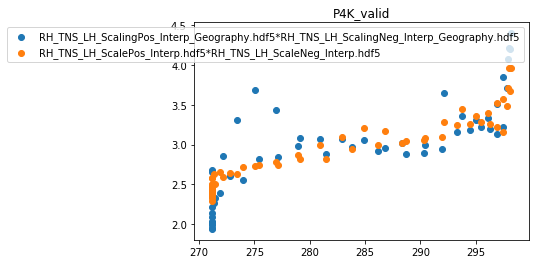

In [45]:
for i,NNs in enumerate(NNarray):
    plt.scatter(np.mean(coor.TS,axis=(0,2)),np.log10(np.mean(MSE[NNs][data[6:-3]],axis=1)),label=NNs)
plt.legend()
plt.title(data[6:-3])

Text(0.5, 1.0, 'P4K_valid')

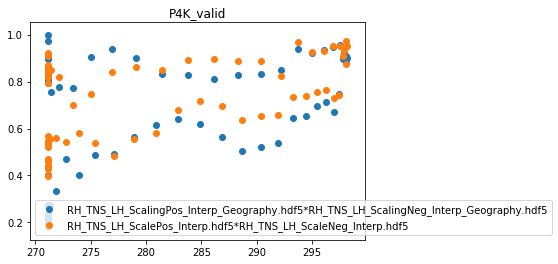

In [46]:
for i,NNs in enumerate(NNarray):
    plt.scatter(np.mean(coor.TS,axis=(0,2)),np.mean(MSE[NNs][data[6:-3]],axis=1)/
                np.mean(VAR[NNs][data[6:-3]],axis=1),label=NNs)
plt.legend()
plt.title(data[6:-3])

In [46]:
MSE

{'samples': 20,
 'RH_TNS_LH_ScalingPos_Interp_Geography.hdf5*RH_TNS_LH_ScalingNeg_Interp_Geography.hdf5': 715.081431196014,
 'RH_TNS_LH_ScalePos_Interp.hdf5*RH_TNS_LH_ScaleNeg_Interp.hdf5': 650.9503243758248}

In [40]:
data

'CI_SP_P4K_valid.nc'

In [ ]:
lat_ind = np.arange(0,64)
iinis = [500]

# diagno = {} # Diagnostics structure
# diagno['truth'] = {} # Diagnostics structure for the truth
# diagno['truth_pos'] = {} # Diagnostics structure for the truth pos
# diagno['truth_neg'] = {} # Diagnostics structure for the truth neg
# truth_done = {}

# for j,data in enumerate(data_file):
#     truth_done[data[6:-3]] = False

for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]]={}
        if i==0: 
#             diagno['truth'][data[6:-3]]={}
#             diagno['truth_pos'][data[6:-3]]={}
#             diagno['truth_neg'][data[6:-3]]={}
        for iini in iinis:
            
            print('j=',j,'& iini=',iini,'& data=',data,'         ',end='\r'),
            
            iend = iini+47
            diagno[NNs][data[6:-3]][iini] = {} # Diagnostics structure for each data file
            if i==0: 
                diagno['truth'][data[6:-3]][iini] = {}
                diagno['truth_pos'][data[6:-3]][iini] = {}
                diagno['truth_neg'][data[6:-3]][iini] = {}
                
            for itime in tqdm(np.arange(iini,iend)):
                # Get input, prediction and truth from NN
                inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
                ## only if the scaling is true
                if NN[NNs].scaling==True:
                    X, _ = md[NNs][data[6:-3]].valid_gen[itime]
                    mask, pos_op, neg_op = md[NNs][data[6:-3]].model.predict_on_batch_seperate(X.values)
                    mask_reshaped = md[NNs][data[6:-3]].reshape_ngeo(mask)[lat_ind,:,:]
                    mask = mask_reshaped.flatten()
                    neg_mask = np.logical_not(mask)
                    ## get the truth only once.
                p = np.array(p)
                # Get convective heating and moistening for each NN
                if itime==iini:
                    if i==0:
                        diagno['truth'][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                        diagno['truth'][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                    ##if scaling is true and the truth array is not filled
                    if NN[NNs].scaling==True and truth_done[data[6:-3]]==False:
                        diagno['truth_pos'][data[6:-3]][iini]['PHQ_pos'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno['truth_pos'][data[6:-3]][iini]['TPHYSTND_pos'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno['truth_neg'][data[6:-3]][iini]['PHQ_neg'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        diagno['truth_neg'][data[6:-3]][iini]['TPHYSTND_neg'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        truth_done[data[6:-3]] = True
                                                    
                    diagno[NNs][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                    if NN[NNs].scaling==True:
                        diagno[NNs][data[6:-3]][iini]['PHQ_pos'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno[NNs][data[6:-3]][iini]['TPHYSTND_pos'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno[NNs][data[6:-3]][iini]['PHQ_neg'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        diagno[NNs][data[6:-3]][iini]['TPHYSTND_neg'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]

                else:
                    for istr,field in enumerate(['PHQ','TPHYSTND']):
                        if field=='PHQ': ind_field = PHQ_idx
                        elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                        diagno[NNs][data[6:-3]][iini][field] = np.concatenate((diagno[NNs][data[6:-3]][iini][field],
                                                             md[NNs][data[6:-3]].\
                                                             reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)
                        if NN[NNs].scaling==True:
                            diagno[NNs][data[6:-3]][iini][field+'_pos'] = np.concatenate((diagno[NNs][data[6:-3]][iini][field+'_pos'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask]),
                                        axis=0)

                            diagno[NNs][data[6:-3]][iini][field+'_neg'] = np.concatenate((diagno[NNs][data[6:-3]][iini][field+'_neg'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[neg_mask]),
                                        axis=0)
                        if i==0:
                            diagno['truth'][data[6:-3]][iini][field] = np.concatenate((diagno['truth'][data[6:-3]][iini][field],
                                                                     md[NNs][data[6:-3]].\
                                                                     reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                    axis=3)
                            
                            if NN[NNs].scaling==True:
                                diagno['truth_pos'][data[6:-3]][iini][field+'_pos'] = np.concatenate((diagno['truth_pos'][data[6:-3]][iini][field+'_pos'],
                                             md[NNs][data[6:-3]].\
                                             reshape_ngeo(truth[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask]),
                                            axis=0)
                                diagno['truth_neg'][data[6:-3]][iini][field+'_neg'] = np.concatenate((diagno['truth_neg'][data[6:-3]][iini][field+'_neg'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(truth[:,ind_field])[lat_ind,:,:].reshape(-1,30)[neg_mask]),
                                        axis=0)

### Convective heating and moistening movie

From [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/034_AGU2019_Figures.ipynb]

In [67]:
data_file

['geography/CI_SP_M4K_train.nc']

In [68]:
data = data_file[0]

In [69]:
lat_ind = np.arange(0,64)
iini = 2000
iend = 2005

diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
for i,NNs in enumerate([NNarray[0]]):
    diagno[NNs] = {} # Diagnostics structure for each NN
    for itime in tqdm(np.arange(iini,iend)):
        # Get input, prediction and truth from NN
        inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        p = p.numpy()
        # Get convective heating and moistening for each NN
        if itime==iini:
            if i==0:
                diagno['truth']['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                diagno['truth']['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
            diagno[NNs]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
            diagno[NNs]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
        else:
            for istr,field in enumerate(['PHQ','TPHYSTND']):
                if field=='PHQ': ind_field = PHQ_idx
                elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                diagno[NNs][field] = np.concatenate((diagno[NNs][field],
                                                     md[NNs][data[6:-3]].reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                    axis=3)
                if i==0:
                    diagno['truth'][field] = np.concatenate((diagno['truth'][field],
                                                             md[NNs][data[6:-3]].reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)

/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [70]:
# Plot characteristics
fz = 17.5
lw = 2
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

In [71]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

0
1


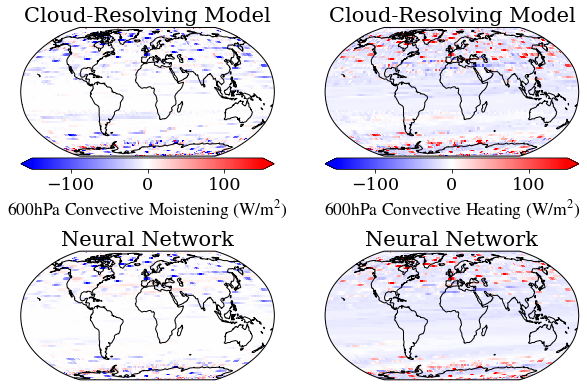

In [74]:
pathHOME = '/home/tbeucler/Movie_IGARSS/'
vminQ = -150
vmaxQ = 150
vminT = -150
vmaxT = 150
iz = -11 # -11 is 600hPa
it = 0

for it in range(100):
    print(it)

    plt.close('all')

    fig,ax = plt.subplots(2,2,figsize=(10,7.5),subplot_kw=dict(projection=ccrs.Robinson()))

    # (a) Convective Moistening
    im = ax[0,0].imshow(diagno['truth']['PHQ'][:,:,iz,it],cmap='bwr',vmin=vminQ,vmax=vmaxQ,transform=ccrs.PlateCarree())
    #im = ax[0,0].imshow(coor.TS[it,:,:].values,cmap='bwr',transform=ccrs.PlateCarree())
    ax[0,0].set_title('Cloud-Resolving Model')
    ax[0,0].set_global()
    ax[0,0].add_feature(cfeature.COASTLINE)
    cb = fig.colorbar(im, ax=ax[0,0], pad=0.01, extend='both', orientation='horizontal'); 
    cb.set_label('$\mathrm{600hPa\ Convective\ Moistening\ (W/m^{2})}$')

    # (b) Convective Heating
    im = ax[0,1].imshow(diagno['truth']['TPHYSTND'][:,:,iz,it],cmap='bwr',vmin=vminT,vmax=vmaxT,transform=ccrs.PlateCarree())
    ax[0,1].set_title('Cloud-Resolving Model')
    ax[0,1].add_feature(cfeature.COASTLINE)
    cb = fig.colorbar(im, ax=ax[0,1], pad=0.01, extend='both', orientation='horizontal'); 
    cb.set_label('$\mathrm{600hPa\ Convective\ Heating\ (W/m^{2})}$')

    # (a) Convective Moistening
    im = ax[1,0].imshow(diagno[NNs]['PHQ'][:,:,iz,it],cmap='bwr',vmin=vminQ,vmax=vmaxQ,transform=ccrs.PlateCarree())
    ax[1,0].set_title('Neural Network')
    ax[1,0].add_feature(cfeature.COASTLINE)
    #cb = fig.colorbar(im, ax=ax[1,0], pad=0.01, extend='both', orientation='horizontal'); 
    #cb.set_label('$\mathrm{PRED\ 600hPa\ Convective\ Moistening\ (W/m^{2})}$')

    # (b) Convective Heating
    im = ax[1,1].imshow(diagno[NNs]['TPHYSTND'][:,:,iz,it],cmap='bwr',vmin=vminT,vmax=vmaxT,transform=ccrs.PlateCarree())
    ax[1,1].set_title('Neural Network')
    ax[1,1].add_feature(cfeature.COASTLINE)
    #cb = fig.colorbar(im, ax=ax[1,1], pad=0.01, extend='both', orientation='horizontal'); 
    #cb.set_label('$\mathrm{PRED\ 600hPa\ Convective\ Heating\ (W/m^{2})}$')

    # matplotlib.pyplot.gcf().suptitle("Time to Crash: "+"%02.1f"%(cam_ds.time[-1]-cam_ds.time[it])+"day",
    #                                  fontsize=fz)
    #plt.savefig(pathHOME+str(it)+'.png',format='png')

## Retraining the NN to prepare for transfer learning

### Real-geography setting

In [29]:
NN

{'BF_Geography.hdf5': <__main__.ClimateNet at 0x2acd15f6f748>,
 'RH_Geography.hdf5': <__main__.ClimateNet at 0x2acd164c70f0>,
 'RH_TNS_Geography.hdf5': <__main__.ClimateNet at 0x2acd16cbcc18>,
 'RH_TNS_LHQsat_Geography.hdf5': <__main__.ClimateNet at 0x2acd178a5d30>,
 'RH_TNS_LH_ScalingPos_Geography.hdf5*RH_TNS_LH_ScalingNeg_Geography.hdf5': <__main__.ClimateNet at 0x2acd17ba9128>,
 'RH_TNS_LH_ScalingPos_Interp_Geography.hdf5*RH_TNS_LH_ScalingNeg_Interp_Geography.hdf5': <__main__.ClimateNet at 0x2acd718269b0>}

In [30]:
BF_geog = NN['RH_TNS_LHQsat_Geography.hdf5'].model

In [31]:
BF_geog.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 128)               0   

In [32]:
# Where to save the model
path_HDF5 = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/'
save_name = 'RH_TNS_LHSAT_geog_2020_07_22'

In [33]:
#model.compile(tf.keras.optimizers.Adam(), loss=mse)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [34]:
train_gen[0][0].shape

(1024, 64)

In [ ]:
Nep = 10
BF_geog.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save_pos])

Epoch 1/10
30780/30780 [==============================] - 2847s 92ms/step - loss: 249.4223 - val_loss: 255.9383
Epoch 2/10
30780/30780 [==============================] - 2893s 94ms/step - loss: 246.1494 - val_loss: 250.4497
Epoch 3/10
30780/30780 [==============================] - 2762s 90ms/step - loss: 243.7750 - val_loss: 250.5162
Epoch 4/10
30780/30780 [==============================] - 2792s 91ms/step - loss: 242.0616 - val_loss: 248.9424
Epoch 5/10
30780/30780 [==============================] - 2730s 89ms/step - loss: 240.6029 - val_loss: 252.0199
Epoch 6/10
30780/30780 [==============================] - 2648s 86ms/step - loss: 239.4115 - val_loss: 247.7842
Epoch 7/10
30780/30780 [==============================] - 2914s 95ms/step - loss: 238.3418 - val_loss: 246.5789
Epoch 8/10
30780/30780 [==============================] - 2783s 90ms/step - loss: 237.4444 - val_loss: 249.0680
Epoch 9/10
30780/30780 [==============================] - 2740s 89ms/step - loss: 236.6686 - val_loss: 2

## Transfer Learning experiments

### From CI aqua to CI geo

In [38]:
if geography: path = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/geography/'
else: path = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'

In [39]:
por_array = [0.01,0.1,1]

In [40]:
por_array

[0.01, 0.1, 1]

In [41]:
Nep = 10

In [42]:
data = 'CI_SP_M4K_valid.nc'

In [43]:
NN = {}
for i,por in enumerate(por_array):
    print('por=',por)
    graph = tf.Graph()
    
    # 1) Define new generators
    TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
    NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
    VALIDFILE = 'CI_SP_M4K_valid.nc'
    config_file = 'CI_SP_M4K_CONFIG.yml'

    train_gen = DataGeneratorClimInv(
        data_fn = path+TRAINFILE,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path+NORMFILE,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        batch_size=1024,
        shuffle=True,
        lev=lev,
        hyam=hyam,hybm=hybm,
        inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
        inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
        rh_trans=True,t2tns_trans=True,
        lhflx_trans=True,scaling=False,interpolate=False,portion=por)

    valid_gen = DataGeneratorClimInv(
        data_fn = path+VALIDFILE,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path+NORMFILE,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        batch_size=1024,
        shuffle=True,
        lev=lev,
        hyam=hyam,hybm=hybm,
        inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
        inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
        rh_trans=True,t2tns_trans=True,
        lhflx_trans=True,scaling=False,interpolate=False
    )
    
    # 2) Load model
    path_NN = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/RH_TNS_LHSAT_geog_2020_07_22.hdf5'
    NN[por] = load_climate_model(dict_lay,'/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                         '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data,
                                         lev=lev,hyam=hyam,hybm=hybm,TRAINDIR=TRAINDIR,
                                         inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
                                         inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
                                         rh_trans=rh_trans,t2tns_trans=t2tns_trans,
                                         lhflx_trans=lhflx_trans,scaling=scaling,interpolate=interpolate,
                                         model=path_NN,pos_model=pos_model,neg_model=neg_model,
                                          train_gen_RH_pos=train_gen_RH_pos,train_gen_RH_neg=train_gen_RH_neg,
                                            train_gen_TNS_pos=train_gen_TNS_pos,train_gen_TNS_neg=train_gen_TNS_neg  )
    
    # 3) Define callbacks and save_name of new model
    path_HDF5 = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/'
    save_name = 'TL_CI_Geog_2020_07_23_porindex_'+str(i+3)
    earlyStopping = EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
    mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='loss', mode='min')

    # 4) Train model for Nep epochs and CANNOT save state of best validation loss because
    # it would NOT be consistent with transfer learning scenario
    NN[por].model.fit_generator(train_gen, epochs=Nep, callbacks=[earlyStopping, mcp_save_pos])

por= 0.01


/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Epoch 1/10
41376/41376 [==============================] - 961s 23ms/step - loss: 296.2065
Epoch 2/10
41376/41376 [==============================] - 956s 23ms/step - loss: 209.9406
Epoch 3/10
41376/41376 [==============================] - 1003s 24ms/step - loss: 183.1219
Epoch 4/10
41376/41376 [==============================] - 965s 23ms/step - loss: 169.0326
Epoch 5/10
41376/41376 [==============================] - 1025s 25ms/step - loss: 160.2496
Epoch 6/10
41376/41376 [==============================] - 1040s 25ms/step - loss: 154.2399
Epoch 7/10
41376/41376 [==============================] - 1042s 25ms/step - loss: 149.8306
Epoch 8/10
41376/41376 [==============================] - 1026s 25ms/step - loss: 146.4640
Epoch 9/10
41376/41376 [==============================] - 1018s 25ms/step - loss: 143.6004
Epoch 10/10
41376/41376 [==============================] - 1052s 25ms/step - loss: 141.1602
por= 0.1


/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Epoch 1/10
41376/41376 [==============================] - 1027s 25ms/step - loss: 121.4488
Epoch 2/10
41376/41376 [==============================] - 1027s 25ms/step - loss: 53.8560
Epoch 3/10
41376/41376 [==============================] - 1024s 25ms/step - loss: 42.9020
Epoch 4/10
41376/41376 [==============================] - 945s 23ms/step - loss: 37.2870
Epoch 5/10
41376/41376 [==============================] - 910s 22ms/step - loss: 33.7949
Epoch 6/10
41376/41376 [==============================] - 909s 22ms/step - loss: 31.2072
Epoch 7/10
41376/41376 [==============================] - 930s 22ms/step - loss: 29.3303
Epoch 8/10
41376/41376 [==============================] - 927s 22ms/step - loss: 27.7835
Epoch 9/10
41376/41376 [==============================] - 914s 22ms/step - loss: 26.5213
Epoch 10/10
41376/41376 [==============================] - 914s 22ms/step - loss: 25.4314
por= 1


/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Epoch 1/10
41376/41376 [==============================] - 1057s 26ms/step - loss: 368.1085
Epoch 2/10
41376/41376 [==============================] - 915s 22ms/step - loss: 351.6753
Epoch 3/10
41376/41376 [==============================] - 913s 22ms/step - loss: 347.9348
Epoch 4/10
41376/41376 [==============================] - 911s 22ms/step - loss: 345.7655
Epoch 5/10
41376/41376 [==============================] - 947s 23ms/step - loss: 344.3355
Epoch 6/10
41376/41376 [==============================] - 909s 22ms/step - loss: 343.2526
Epoch 7/10
41376/41376 [==============================] - 914s 22ms/step - loss: 342.3159
Epoch 8/10
41376/41376 [==============================] - 912s 22ms/step - loss: 341.5674
Epoch 9/10
41376/41376 [==============================] - 947s 23ms/step - loss: 340.9197
Epoch 10/10
41376/41376 [==============================] - 908s 22ms/step - loss: 340.3807


tgb - 7/24/2020 - Legacy; restarting from 0.01 (i+3) above

In [39]:
por_array = [0.00001,0.0001,0.001,0.01,0.1,1]

In [40]:
por_array

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1]

In [41]:
Nep = 10

In [42]:
data = 'CI_SP_M4K_valid.nc'

In [ ]:
NN = {}
for i,por in enumerate(por_array):
    print('por=',por)
    graph = tf.Graph()
    
    # 1) Define new generators
    TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
    NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
    VALIDFILE = 'CI_SP_M4K_valid.nc'
    config_file = 'CI_SP_M4K_CONFIG.yml'

    train_gen = DataGeneratorClimInv(
        data_fn = path+TRAINFILE,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path+NORMFILE,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        batch_size=1024,
        shuffle=True,
        lev=lev,
        hyam=hyam,hybm=hybm,
        inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
        inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
        rh_trans=True,t2tns_trans=True,
        lhflx_trans=True,scaling=False,interpolate=False,portion=por)

    valid_gen = DataGeneratorClimInv(
        data_fn = path+VALIDFILE,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path+NORMFILE,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        batch_size=1024,
        shuffle=True,
        lev=lev,
        hyam=hyam,hybm=hybm,
        inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
        inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
        rh_trans=True,t2tns_trans=True,
        lhflx_trans=True,scaling=False,interpolate=False
    )
    
    # 2) Load model
    path_NN = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/RH_TNS_LHSAT_geog_2020_07_22.hdf5'
    NN[por] = load_climate_model(dict_lay,'/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                         '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data,
                                         lev=lev,hyam=hyam,hybm=hybm,TRAINDIR=TRAINDIR,
                                         inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
                                         inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
                                         rh_trans=rh_trans,t2tns_trans=t2tns_trans,
                                         lhflx_trans=lhflx_trans,scaling=scaling,interpolate=interpolate,
                                         model=path_NN,pos_model=pos_model,neg_model=neg_model,
                                          train_gen_RH_pos=train_gen_RH_pos,train_gen_RH_neg=train_gen_RH_neg,
                                            train_gen_TNS_pos=train_gen_TNS_pos,train_gen_TNS_neg=train_gen_TNS_neg  )
    
    # 3) Define callbacks and save_name of new model
    path_HDF5 = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/'
    save_name = 'TL_CI_Geog_2020_07_23_porindex_'+str(i)
    earlyStopping = EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
    mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='loss', mode='min')

    # 4) Train model for Nep epochs and CANNOT save state of best validation loss because
    # it would NOT be consistent with transfer learning scenario
    NN[por].model.fit_generator(train_gen, epochs=Nep, callbacks=[earlyStopping, mcp_save_pos])

por= 1e-05


/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Epoch 1/10
41376/41376 [==============================] - 3188s 77ms/step - loss: 368.0643
Epoch 2/10
41376/41376 [==============================] - 1006s 24ms/step - loss: 351.7697
Epoch 3/10
41376/41376 [==============================] - 1013s 24ms/step - loss: 347.9576
Epoch 4/10
41376/41376 [==============================] - 1004s 24ms/step - loss: 345.7857
Epoch 5/10
41376/41376 [==============================] - 1005s 24ms/step - loss: 344.2860
Epoch 6/10
41376/41376 [==============================] - 1014s 25ms/step - loss: 343.1214
Epoch 7/10
41376/41376 [==============================] - 1049s 25ms/step - loss: 342.1189
Epoch 8/10
41376/41376 [==============================] - 1026s 25ms/step - loss: 341.3883
Epoch 9/10
41376/41376 [==============================] - 1058s 26ms/step - loss: 340.7951
Epoch 10/10
41376/41376 [==============================] - 1038s 25ms/step - loss: 340.2174
por= 0.0001


/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Epoch 1/10
41376/41376 [==============================] - 1023s 25ms/step - loss: 369.4778
Epoch 2/10
41376/41376 [==============================] - 1033s 25ms/step - loss: 352.1623
Epoch 3/10
41376/41376 [==============================] - 1064s 26ms/step - loss: 348.1718
Epoch 4/10
41376/41376 [==============================] - 1017s 25ms/step - loss: 345.8140
Epoch 5/10
41376/41376 [==============================] - 1021s 25ms/step - loss: 344.1861
Epoch 6/10
41376/41376 [==============================] - 1010s 24ms/step - loss: 342.9450
Epoch 7/10
41376/41376 [==============================] - 1014s 25ms/step - loss: 341.9805
Epoch 8/10
41376/41376 [==============================] - 1036s 25ms/step - loss: 341.1583
Epoch 9/10
41376/41376 [==============================] - 1076s 26ms/step - loss: 340.4409
Epoch 10/10
41376/41376 [==============================] - 1035s 25ms/step - loss: 339.8731
por= 0.001


/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Epoch 1/10
41376/41376 [==============================] - 1020s 25ms/step - loss: 367.5721
Epoch 2/10
41376/41376 [==============================] - 1019s 25ms/step - loss: 344.1484
Epoch 3/10
41376/41376 [==============================] - 1023s 25ms/step - loss: 334.1300
Epoch 4/10
41376/41376 [==============================] - 1020s 25ms/step - loss: 326.3844
Epoch 5/10
41376/41376 [==============================] - 966s 23ms/step - loss: 319.9743
Epoch 6/10
41376/41376 [==============================] - 988s 24ms/step - loss: 314.6469
Epoch 7/10
41376/41376 [==============================] - 1033s 25ms/step - loss: 310.2864
Epoch 8/10
41376/41376 [==============================] - 1020s 25ms/step - loss: 306.6519
Epoch 9/10
41376/41376 [==============================] - 1018s 25ms/step - loss: 303.4880
Epoch 10/10
19299/41376 [============>.................] - ETA: 9:34 - loss: 301.5969